In [1]:
## global imports 
import pandas as pd 
import numpy as np 
import jgraph 
from datetime import datetime

In [ ]:
# read the data and harmonise = > takes a while to run
file_path= './data/'

covid_df = pd.read_csv(file_path + '/covid19-US.csv')

state_abbreviations_df = pd.read_csv(file_path + '/state_abbreviations.csv' )
abbreviations_dict = dict(zip(state_abbreviations_df.State, state_abbreviations_df.Code)) 

col_list = ['FL_DATE', 'ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'FLIGHTS']

flight_jan19 = pd.read_csv(file_path + '/flights-jan19.csv', usecols=col_list)
flight_jan20 = pd.read_csv(file_path + '/flights-jan20.csv', usecols=col_list)
flight_feb19 = pd.read_csv(file_path + '/flights-feb19.csv', usecols=col_list)
flight_mar19 = pd.read_csv(file_path + '/flights-mar19.csv', usecols=col_list)
flight_apr19 = pd.read_csv(file_path + '/flights-apr19.csv', usecols=col_list)

## harmonise dataframes 
# convert to datetime makes things slightly faster 
covid_df['date']= pd.to_datetime(covid_df.date) 
covid_df['day'] = covid_df.date.apply(lambda x: x.day)
covid_df['month'] = covid_df.date.apply(lambda x: x.month)
# name origin as that is how we will agregate
covid_df['origin_state'] = covid_df.state.apply(lambda x: abbreviations_dict[x] if x in abbreviations_dict.keys() else 'other')
covid_df['year'] = 2020

## this is what takes a lot of time 
flight_df = flight_jan20
flight_df = flight_df.append([flight_jan19, flight_feb19, flight_mar19, flight_apr19], ignore_index = True) 

## might not need that but could be useful later ..takes a while  
flight_df['FL_DATE']= pd.to_datetime(flight_df.FL_DATE) 
flight_df['day'] = flight_df.FL_DATE.apply(lambda x: x.day)
flight_df['month'] = flight_df.FL_DATE.apply(lambda x: x.month)
flight_df['year'] = flight_df.FL_DATE.apply(lambda x: x.year)

flight_df['origin_state'] = flight_df.ORIGIN_CITY_NAME.apply(lambda x: x.strip().split()[-1])
flight_df['dest_state'] = flight_df.DEST_CITY_NAME.apply(lambda x: x.strip().split()[-1])

flight_df = flight_df.drop(['ORIGIN_CITY_NAME', 'DEST_CITY_NAME', 'FL_DATE'], axis =1)
covid_df = covid_df.drop(['date', 'county', 'fips', 'state'], axis = 1)



In [ ]:
## aggregate and sum
flight_df = flight_df.groupby(['day', 'month', 'year', 'origin_state', 
                               'dest_state'])['FLIGHTS'].sum().reset_index().fillna(0)

In [ ]:
flight_mar19

In [ ]:
flight_df.loc[flight_df.month==3]


In [ ]:
print('FLIGHT shape:', flight_df.shape)
print('COVID shape:', covid_df.shape)

In [ ]:
covid_df.head()


In [ ]:
import networkx as nx 
## create death and case graphs for a certain date
# choose date of interest 
day = 1
month = 4
year = 2019 

interesting_flight_data = flight_df.loc[(flight_df.day == day) & 
                                        (flight_df.month == month) &
                                        (flight_df.year == year)]

interesting_covid_data = covid_df.loc[(covid_df.day == day) & 
                                     (covid_df.month == month), ['cases', 'deaths', 'origin_state']]

interesting_covid_data = interesting_covid_data.groupby(['origin_state'])['deaths', 
                                                                          'cases'].sum().reset_index().fillna(0)

print('Flight-data-of-interest shape:', interesting_flight_data.shape)
print('Covid-data-of-interest shape:', interesting_covid_data.shape)

# create death graph 
edge_weights = [i / np.max(interesting_flight_data.FLIGHTS) for i in interesting_flight_data.FLIGHTS]
nodes = list(abbreviations_dict.values()) + ['other']
death_graph = nx.DiGraph()
death_graph.add_nodes_from(nodes)

deaths_dict = dict(zip(interesting_covid_data.origin_state, interesting_covid_data.deaths))
cases_dict = dict(zip(interesting_covid_data.origin_state, interesting_covid_data.cases))

for node in nodes: 
    ## look up for weight of node else 0 
    weight = 0 
    if node in deaths_dict.keys():
        weight = deaths_dict[node]
    
    death_graph.add_node(node, weight=weight)

for origin, dest, weight in zip(interesting_flight_data.origin_state, 
                           interesting_flight_data.dest_state, edge_weights):
    death_graph.add_edge(origin, dest, weight = weight)

    

# create case graph
edge_weights = [i / np.max(interesting_flight_data.FLIGHTS) for i in interesting_flight_data.FLIGHTS]
nodes = list(abbreviations_dict.values()) + ['other']
case_graph = nx.DiGraph()
case_graph.add_nodes_from(nodes)

cases_dict = dict(zip(interesting_covid_data.origin_state, interesting_covid_data.cases))

for node in nodes: 
    ## look up for weight of node else 0 
    weight = 0 
    if node in cases_dict.keys():
        weight = cases_dict[node]
    
    case_graph.add_node(node, weight=weight)

for origin, dest, weight in zip(interesting_flight_data.origin_state, 
                           interesting_flight_data.dest_state, edge_weights):
    case_graph.add_edge(origin, dest, weight = weight)

In [ ]:
interesting_covid_data.head()

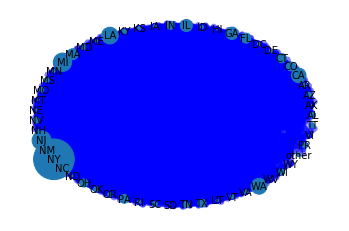

In [211]:
## This is to print the graph --need to do something with 

# import matplotlib.pyplot as plt
# pos = nx.drawing.layout.circular_layout(death_graph)

# elarge = [(u, v) for (u, v, d) in death_graph.edges(data=True) if d['weight'] > 0.5]
# esmall = [(u, v) for (u, v, d) in death_graph.edges(data=True) if d['weight'] <= 0.5]

# #pos = nx.spring_layout(death_graph)  # positions for all nodes

# # nodesG.nodes(data='weight'
# weights = [w for w in list(nx.get_node_attributes(death_graph,'weight').values())]* 10000
# nx.draw_networkx_nodes(death_graph.nodes, pos, node_size = weights)

# # edges
# nx.draw_networkx_edges(death_graph, pos, edgelist=elarge,
#                        width=6)
# nx.draw_networkx_edges(death_graph, pos, edgelist=esmall,
#                        width=6, alpha=0.5, edge_color='b', style='dashed')

# # labels
# nx.draw_networkx_labels(death_graph, pos, font_size=10, font_family='sans-serif')

# plt.axis('off')
# plt.show()